In [1]:
import os
import rosbag
from data_loader.ros_msg.pointcloud import PointCloud
from data_loader.ros_msg.image import Image
from data_loader.ros_msg.odometry import Odometry
from data_loader.calib.intrinsic_extrinsic_loader import IntrinsicExtrinsicLoader
from data_loader.file_loader import FileLoader
from data_loader.file_writer import FileWriter
from tools.utils import *

platform = 'vehicle'
sequence_name = 'vehicle_highway00'
algorithm = 'r3live'

In [2]:
##### Set up the output data path
dataset_path = '/Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined'

##### Set up the message topic list for different platforms
if platform =='vehicle':
  from cfg.dataset.cfg_vehicle import dataset_sensor_frameid_dict
  from cfg.dataset.cfg_vehicle import dataset_rostopic_msg_frameid_dict

if algorithm == 'r3live':
  from cfg.algorithm.cfg_r3live import algorithm_rostopic_msg_frameid_dict

##### Set up the sensor configuration
int_ext_loader = IntrinsicExtrinsicLoader(is_print=False)
int_ext_loader.load_calibration(calib_path=os.path.join(dataset_path, '../../calibration_files/20230618_calib/calib'), \
                                sensor_frameid_dict=dataset_sensor_frameid_dict)
print('Finish loading parameters')

data_path = os.path.join(dataset_path, sequence_name, 'raw_data')
alg_result_path = os.path.join(dataset_path, sequence_name, 'algorithm_result')
file_loader = FileLoader()

Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibration_files/20230618_calib/calib/ouster00.yaml ...
Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibration_files/20230618_calib/calib/event_cam00.yaml ...
Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibration_files/20230618_calib/calib/event_cam01.yaml ...
Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibration_files/20230618_calib/calib/frame_cam00.yaml ...
Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibration_files/20230618_calib/calib/frame_cam01.yaml ...
Loading Intrinsic Extrinsics from /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/../../calibra

In [3]:
##### Load timestamp from alg_result
# NOTE(gogojjh): the frame_id of Ouster_undistort should be the body_imu not ouster00
# Ouster_undistort
if 'ouster_points_undistorted' in algorithm_rostopic_msg_frameid_dict.keys():
  ouster_un_timestamps = file_loader.load_timestamp(os.path.join(alg_result_path, 'ouster00_undistort/points/timestamps.txt')) 
  print('Loading ouster_un_timestamps: {}'.format(len(ouster_un_timestamps)))

##### Load timestamp from raw_data
# Ouster
if 'ouster_points' in dataset_rostopic_msg_frameid_dict.keys():
  ouster_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'ouster00/points/timestamps.txt')) 
  print('Loading ouster_timestamps: {}'.format(len(ouster_timestamps)))

# Frame_camera
if platform =='vehicle':
  if 'vehicle_frame_left_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_left_image_timestamps = file_loader.load_timestamp(os.path.join(data_path,'vehicle_frame_cam00/image/timestamps.txt'))
    print('Loading vehicle_left_timestamps: {}'.format(len(frame_left_image_timestamps)))
  if 'vehicle_frame_right_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_right_image_timestamps = file_loader.load_timestamp(os.path.join(data_path,'vehicle_frame_cam01/image/timestamps.txt'))
    print('Loading vehicle_right_timestamps: {}'.format(len(frame_right_image_timestamps)))
else:
  if 'frame_left_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_left_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'frame_cam00/image/timestamps.txt'))
    print('Loading frame_left_timestamps: {}'.format(len(frame_left_image_timestamps)))
  if 'frame_right_image' in dataset_rostopic_msg_frameid_dict.keys():
    frame_right_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'frame_cam01/image/timestamps.txt'))
    print('Loading frame_right_timestamps: {}'.format(len(frame_right_image_timestamps)))
    
# Event_camera
if 'event_left_image' in dataset_rostopic_msg_frameid_dict.keys():
  event_left_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'event_cam00/image/timestamps.txt'))
  print('Loading event_left_timestamps: {}'.format(len(event_left_image_timestamps)))
if 'event_right_image' in dataset_rostopic_msg_frameid_dict.keys():
  event_right_image_timestamps = file_loader.load_timestamp(os.path.join(data_path, 'event_cam01/image/timestamps.txt'))
  print('Loading event_right_timestamps: {}'.format(len(event_right_image_timestamps)))

##### Match synchronized timestamps
matched_id_ouster_un_sensors = []
for id, time in enumerate(ouster_un_timestamps):
  ouster_time, ouster_id = find_closest_element_sorted(ouster_timestamps, time)
  fl_time, fli_id = find_closest_element_sorted(frame_left_image_timestamps, time)
  fr_time, flr_id = find_closest_element_sorted(frame_right_image_timestamps, fl_time)
  el_time, eli_id = find_closest_element_sorted(event_left_image_timestamps, time)
  er_time, elr_id = find_closest_element_sorted(event_right_image_timestamps, el_time)

  """
  # Not include event cameras
  if abs(time - ouster_time) < 0.01:
    if abs(time - fl_time) < 0.03 and abs(time - fr_time) < 0.03 and abs(fl_time - fr_time) < 0.015:
      matched_id_ouster_un_sensors.append([id, ouster_id, fli_id, flr_id])
  """

  # Include event cameras
  if abs(time - ouster_time) < 0.01:
    if abs(time - fl_time) < 0.03 and abs(time - fr_time) < 0.03 and abs(fl_time - fr_time) < 0.015:
      if abs(time - el_time) < 0.03 and abs(time - er_time) < 0.03 and abs(el_time - er_time) < 0.03:
        matched_id_ouster_un_sensors.append([id, ouster_id, fli_id, flr_id, eli_id, elr_id])

print('Length of matched id (ouster_un - sensors): {}'.format(len(matched_id_ouster_un_sensors)))

Loading ouster_un_timestamps: 156
Loading ouster_timestamps: 160
Loading vehicle_left_timestamps: 321
Loading vehicle_right_timestamps: 321
Loading event_left_timestamps: 320
Loading event_right_timestamps: 320
Length of matched id (ouster_un - sensors): 156


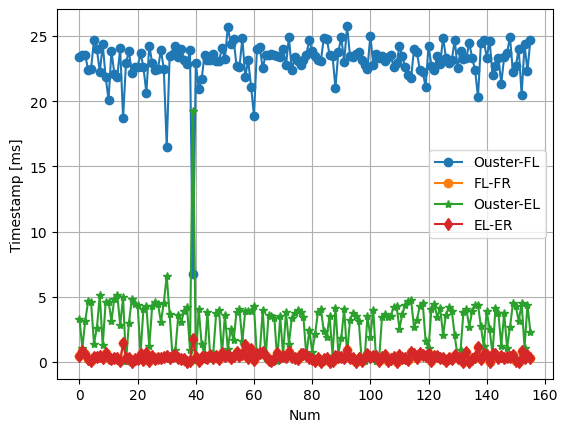

In [4]:
##### Analyze matched timestamps
import matplotlib.pyplot as plt
dt_ouster_fl = [1e3 * abs(ouster_un_timestamps[mid[0]] - frame_left_image_timestamps[mid[2]]) for mid in matched_id_ouster_un_sensors]
dt_fl_fr = [1e3 * abs(frame_left_image_timestamps[mid[2]] - frame_right_image_timestamps[mid[3]]) for mid in matched_id_ouster_un_sensors]
num = [i for i in range(0, len(matched_id_ouster_un_sensors))]
plt.plot(num, dt_ouster_fl, label='Ouster-FL', marker='o')
plt.plot(num, dt_fl_fr, label='FL-FR', marker='o')

dt_ouster_el = [1e3 * abs(ouster_un_timestamps[mid[0]] - event_left_image_timestamps[mid[4]]) for mid in matched_id_ouster_un_sensors]
dt_el_er = [1e3 * abs(event_left_image_timestamps[mid[4]] - event_right_image_timestamps[mid[5]]) for mid in matched_id_ouster_un_sensors]
num = [i for i in range(0, len(matched_id_ouster_un_sensors))]
plt.plot(num, dt_ouster_el, label='Ouster-EL', marker='*')
plt.plot(num, dt_fl_fr, label='EL-ER', marker='d')

plt.xlabel('Num') 
plt.ylabel('Timestamp [ms]')
plt.legend()
plt.grid(True)  
plt.show()

In [10]:
kitti_path = os.path.join(dataset_path, sequence_name, 'kitti')
os.system('mkdir -p '+ os.path.join(kitti_path, 'ouster00_undistort/points/data'))
os.system('mkdir -p '+ os.path.join(kitti_path, 'ouster00/points/data'))
if platform == 'vehicle':
  os.system('mkdir -p '+ os.path.join(kitti_path, 'vehicle_frame_cam00/image/data'))
  os.system('mkdir -p '+ os.path.join(kitti_path, 'vehicle_frame_cam01/image/data'))
else:
  os.system('mkdir -p '+ os.path.join(kitti_path, 'frame_cam00/image/data'))
  os.system('mkdir -p '+ os.path.join(kitti_path, 'frame_cam01/image/data'))
os.system('mkdir -p '+ os.path.join(kitti_path, 'event_cam00/image/data'))
os.system('mkdir -p '+ os.path.join(kitti_path, 'event_cam01/image/data'))

file_writer = FileWriter()

# Save timestamps
select_os_un_timestamps = [ouster_un_timestamps[mid[0]] for mid in matched_id_ouster_un_sensors]
file_writer.write_timestamp(select_os_un_timestamps, os.path.join(kitti_path, 'ouster00_undistort/points/timestamps.txt'))
select_os_timestamps = [ouster_timestamps[mid[1]] for mid in matched_id_ouster_un_sensors]
file_writer.write_timestamp(select_os_timestamps, os.path.join(kitti_path, 'ouster00/points/timestamps.txt'))
if platform =='vehicle':
  select_fl_time = [frame_left_image_timestamps[mid[2]] for mid in matched_id_ouster_un_sensors]
  file_writer.write_timestamp(select_fl_time, os.path.join(kitti_path, 'vehicle_frame_cam00/image/timestamps.txt'))
  select_fr_time = [frame_right_image_timestamps[mid[3]] for mid in matched_id_ouster_un_sensors]
  file_writer.write_timestamp(select_fr_time, os.path.join(kitti_path, 'vehicle_frame_cam01/image/timestamps.txt'))
else:
  select_fl_time = [frame_left_image_timestamps[mid[2]] for mid in matched_id_ouster_un_sensors]
  file_writer.write_timestamp(select_fl_time, os.path.join(kitti_path, 'frame_cam00/image/timestamps.txt'))
  select_fr_time = [frame_right_image_timestamps[mid[3]] for mid in matched_id_ouster_un_sensors]
  file_writer.write_timestamp(select_fr_time, os.path.join(kitti_path, 'frame_cam01/image/timestamps.txt'))
select_el_time = [event_left_image_timestamps[mid[2]] for mid in matched_id_ouster_un_sensors]
file_writer.write_timestamp(select_el_time, os.path.join(kitti_path, 'event_cam00/image/timestamps.txt'))
select_er_time = [event_right_image_timestamps[mid[3]] for mid in matched_id_ouster_un_sensors]
file_writer.write_timestamp(select_er_time, os.path.join(kitti_path, 'event_cam01/image/timestamps.txt'))

# Copy and paste data
for frame_id, mid in enumerate(matched_id_ouster_un_sensors):
  os_un_data_path = os.path.join(alg_result_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(mid[0]))
  new_data_path = os.path.join(kitti_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(frame_id))
  os.system('cp {} {}'.format(os_un_data_path, new_data_path))

  os_data_path = os.path.join(data_path, 'ouster00/points/data', '{:06d}.pcd'.format(mid[1]))
  new_data_path = os.path.join(kitti_path, 'ouster00/points/data', '{:06d}.pcd'.format(frame_id))
  os.system('cp {} {}'.format(os_data_path, new_data_path))

  if platform == 'vehicle':
    fl_data_path = os.path.join(data_path, 'vehicle_frame_cam00/image/data', '{:06d}.png'.format(mid[2]))
    new_data_path = os.path.join(kitti_path, 'vehicle_frame_cam00/image/data', '{:06d}.png'.format(frame_id))
    os.system('cp {} {}'.format(fl_data_path, new_data_path))
    
    fr_data_path = os.path.join(data_path, 'vehicle_frame_cam01/image/data', '{:06d}.png'.format(mid[3]))
    new_data_path = os.path.join(kitti_path, 'vehicle_frame_cam01/image/data', '{:06d}.png'.format(frame_id))
    os.system('cp {} {}'.format(fr_data_path, new_data_path))
  else:
    fl_data_path = os.path.join(data_path, 'frame_cam00/image/data', '{:06d}.png'.format(mid[2]))
    new_data_path = os.path.join(kitti_path, 'frame_cam00/image/data', '{:06d}.png'.format(frame_id))
    os.system('cp {} {}'.format(fl_data_path, new_data_path))

    fr_data_path = os.path.join(data_path, 'frame_cam01/image/data', '{:06d}.png'.format(mid[3]))
    new_data_path = os.path.join(kitti_path, 'frame_cam01/image/data', '{:06d}.png'.format(frame_id))
    os.system('cp {} {}'.format(fr_data_path, new_data_path))

  el_data_path = os.path.join(data_path, 'event_cam00/image/data', '{:06d}.png'.format(mid[4]))
  new_data_path = os.path.join(kitti_path, 'event_cam00/image/data', '{:06d}.png'.format(frame_id))
  os.system('cp {} {}'.format(el_data_path, new_data_path))

  er_data_path = os.path.join(data_path, 'event_cam01/image/data', '{:06d}.png'.format(mid[5]))
  new_data_path = os.path.join(kitti_path, 'event_cam01/image/data', '{:06d}.png'.format(frame_id))
  os.system('cp {} {}'.format(er_data_path, new_data_path))

print('Finish constructing kitti-type dataset')

Finish constructing kitti-type dataset


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D WARNING] Read PCD failed: unable to open file: /Rocket_ssd/dataset/FusionPortable_dataset_develop/sensor_data/data_refined/vehicle_highway00/raw_data/ouster00_undistort/points/data/000000.pcd
std::vector<Eigen::Vector3d> with 0 elements.
Use numpy.asarray() to access data.
std::vector<Eigen::Vector3d> with 131072 elements.
Use numpy.asarray() to access data.


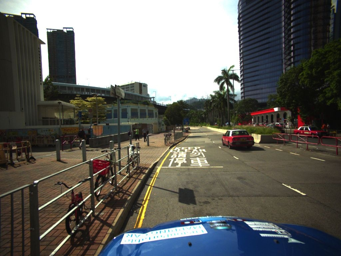

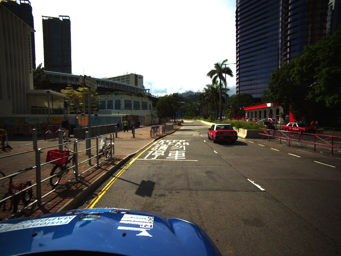

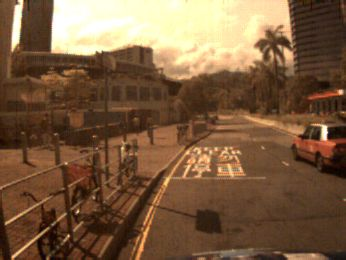

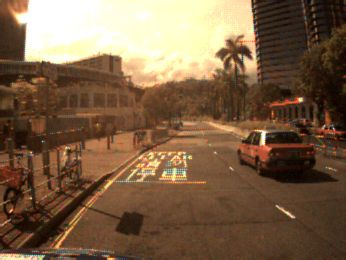

In [11]:
# TEST: visualize data
from PIL import Image
from IPython.display import display
import open3d

frame_id = 0

# Visualize data
pcd_path = os.path.join(kitti_path, 'ouster00_undistort/points/data', '{:06d}.pcd'.format(frame_id))
pcd = open3d.io.read_point_cloud(pcd_path)
print(pcd.points)

pcd_path = os.path.join(kitti_path, 'ouster00/points/data', '{:06d}.pcd'.format(frame_id))
pcd = open3d.io.read_point_cloud(pcd_path)
print(pcd.points)

img_path = os.path.join(kitti_path, 'vehicle_frame_cam00', 'image/data', '{:06d}.png'.format(frame_id))
img = Image.open(img_path)
img_resize = img.resize((img.size[0] // 3, img.size[1] // 3))
display(img_resize)

img_path = os.path.join(kitti_path, 'vehicle_frame_cam01', 'image/data', '{:06d}.png'.format(frame_id))
img = Image.open(img_path)
img_resize = img.resize((img.size[0] // 3, img.size[1] // 3))
display(img_resize)

img_path = os.path.join(kitti_path, 'event_cam00', 'image/data', '{:06d}.png'.format(frame_id))
img = Image.open(img_path)
img_resize = img.resize((img.size[0], img.size[1]))
display(img_resize)

img_path = os.path.join(kitti_path, 'event_cam01', 'image/data', '{:06d}.png'.format(frame_id))
img = Image.open(img_path)
img_resize = img.resize((img.size[0], img.size[1]))
display(img_resize)